In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [242]:
from scipy.stats import norm
from scipy import integrate
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [243]:
rv = norm(loc=3.)

In [244]:
x = np.linspace(-10, 10, 10000)

In [245]:
y = rv.pdf(x)

In [246]:
print(f"rv.ppf(0.05) = {rv.ppf(0.05)}")
print(f"rv.ppf(0.5) = {rv.ppf(0.5)}")
print(f"rv.ppf(0.95) = {rv.ppf(0.95)}")

rv.ppf(0.05) = 1.3551463730485271
rv.ppf(0.5) = 3.0
rv.ppf(0.95) = 4.644853626951472


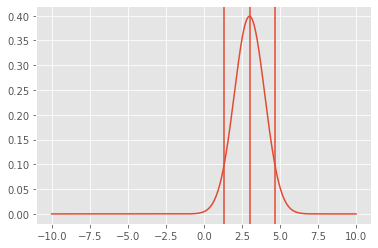

In [247]:
plt.figure()
plt.plot(x, y)

plt.axvline(rv.ppf(0.05))
plt.axvline(rv.ppf(0.5))
plt.axvline(rv.ppf(0.95))

In [248]:
y_norm = y/np.sum(y)

In [249]:
np.sum(x*y)

1499.849999993559

In [250]:
np.sum(x*y_norm)

2.9999999999909286

In [251]:
rv.mean()

3.0

In [253]:
iy = IUS(x, y*x)

In [203]:
iy_norm = IUS(x, x*y_norm)

In [204]:
integrate.quad(iy, x[0], x[-1])

(2.999999999986965, 9.379349634940651e-11)

In [205]:
integrate.quad(iy_norm, x[0], x[-1])

(0.006000600059987741, 9.323605138727739e-11)

In [207]:
integrate.quad(iy, rv.ppf(0.05), rv.ppf(0.95))

(2.699999999999987, 2.0365463140603506e-13)

In [210]:
integrate.quad(iy_norm, rv.ppf(0.05), rv.ppf(0.95))

(0.005400540054012236, 4.0737027731064424e-16)

In [ ]:
# computing the credible interval

$$ \int_C p(\theta|x) \, d\theta = 1 - \alpha$$

In [212]:
from scipy import optimize

In [213]:
def mix_norm_pdf(x, loc, scale, weight):
    from scipy.stats import norm
    return np.dot(weight, norm.pdf(x, loc, scale))

In [214]:
loc    = np.array([-1, 3])   # mean values
scale  = np.array([.5, .8])  # standard deviations
weight = np.array([.4, .6])  # mixture probabilities

In [215]:
def errfn( p, alpha, *args):
    from scipy import integrate
    def fn( x ):
        pdf = mix_norm_pdf(x, *args)
        return pdf if pdf > p else 0

    # ideally integration limits should not
    # be hard coded but inferred
    lb, ub = -3, 6 
    prob = integrate.quad(fn, lb, ub)[0]
    return (prob + alpha - 1.0)**2

In [227]:
# alpha = .05
alpha = .5

from scipy.optimize import fmin
p = fmin(errfn, x0=0, args=(alpha, loc, scale, weight))[0]

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # Remove the CWD from sys.path while we load stuff.


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 42


In [228]:
p

0.2441875000000002

In [229]:
x

array([-10.       ,  -9.9979998,  -9.9959996, ...,   9.9959996,
         9.9979998,  10.       ])

In [230]:
xx = np.linspace(-3, 6, 1000)
args=(alpha, loc, scale, weight)
pdf = np.array([mix_norm_pdf(x, loc, scale, weight) for x in xx])

In [232]:
np.sum(pdf)

110.99288938755001

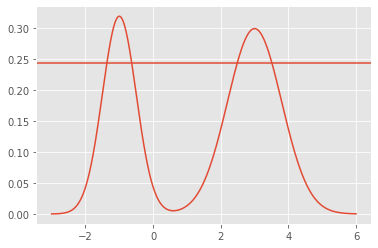

In [231]:
plt.figure()
plt.plot(xx, pdf)
plt.axhline(p)

In [233]:
x[0]

-10.0

In [234]:
x[-1]

10.0

In [254]:
iy_new = IUS(x, y)

In [286]:
# my dataset

def errfn(p, alpha):
    from scipy import integrate
    def fn( x ):
        pdf = iy_new(x)
#         print(x, pdf)
        return pdf if pdf > p else 0

    # ideally integration limits should not
    # be hard coded but inferred
    lb, ub = -10., 10.
    prob = integrate.quad(fn, lb, ub)[0]
    return (prob + alpha - 1.0)**2


alpha = .1
# alpha = .05
# alpha = .5

from scipy.optimize import fmin
p = fmin(errfn, x0=0, args=(alpha,))[0]

/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  del sys.path[0]


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 36


In [285]:
p

0.10312500000000006

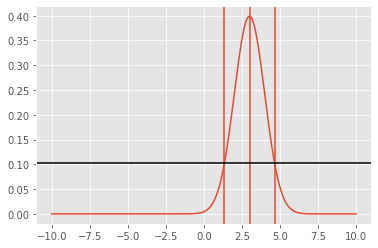

In [283]:
plt.figure()
plt.plot(x, y)

plt.axvline(rv.ppf(0.05))
plt.axvline(rv.ppf(0.5))
plt.axvline(rv.ppf(0.95))
plt.axhline(p, c='k')

# making a nice interface

In [275]:
# https://stackoverflow.com/a/22290087/12840171
def errfn(theta, alpha, lb, ub, objective):
    """
    theta: dependent parameter to perform minimisation
    alpha: credible interval
    lb, ub: lower and upper bound for function / integration limits
    objective: callable function for pdf
    
    returns squared error between p(theta) and (1-alpha)
    """
    from scipy import integrate
    def fn( x ):
        pdf = objective(x)
        return pdf if pdf > theta else 0

    prob = integrate.quad(fn, lb, ub)[0]
    return (prob + alpha - 1.0)**2


from scipy.optimize import fmin

alpha: 0.1
p_lower: 0.05
p_upper: 0.95


/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  from ipykernel import kernelapp as app


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 18
         Function evaluations: 36


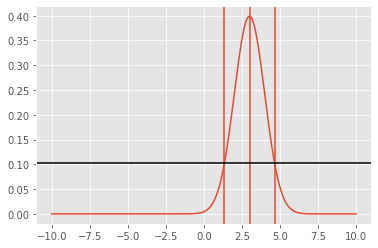

In [276]:

alpha = .1
# alpha = .05
# alpha = .5

p_lower = alpha/2
p_upper = 1-alpha/2

print(f"alpha: {alpha}")
print(f"p_lower: {p_lower}")
print(f"p_upper: {p_upper}")


lb = x[0]
ub = x[-1]

objective = iy_new

p = fmin(errfn, x0=0, args=(alpha,lb,ub,objective))[0]

plt.figure()
plt.plot(x, y)

plt.axvline(rv.ppf(p_lower))
plt.axvline(rv.ppf(0.5))
plt.axvline(rv.ppf(p_upper))
plt.axhline(p, c='k')

alpha: 0.05
p_lower: 0.025
p_upper: 0.975


/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 34


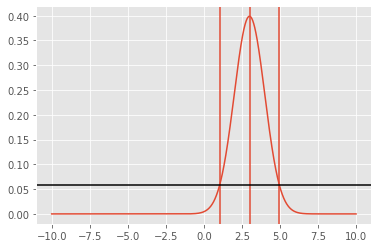

In [273]:

# alpha = .1
alpha = .05
# alpha = .5

p_lower = alpha/2
p_upper = 1-alpha/2

print(f"alpha: {alpha}")
print(f"p_lower: {p_lower}")
print(f"p_upper: {p_upper}")

lb = x[0]
ub = x[-1]

objective = iy_new

p = fmin(errfn, x0=0, args=(alpha,lb,ub,objective))[0]

plt.figure()
plt.plot(x, y)

plt.axvline(rv.ppf(p_lower))
plt.axvline(rv.ppf(0.5))
plt.axvline(rv.ppf(p_upper))
plt.axhline(p, c='k')

alpha: 0.5
p_lower: 0.25
p_upper: 0.75


/Users/spx8sk/anaconda3/envs/scrinet-dev/lib/python3.7/site-packages/ipykernel_launcher.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  if __name__ == '__main__':


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 21
         Function evaluations: 42


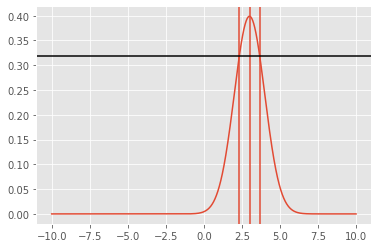

In [274]:

# alpha = .1
# alpha = .05
alpha = .5

p_lower = alpha/2
p_upper = 1-alpha/2

print(f"alpha: {alpha}")
print(f"p_lower: {p_lower}")
print(f"p_upper: {p_upper}")

lb = x[0]
ub = x[-1]

objective = iy_new

p = fmin(errfn, x0=0, args=(alpha,lb,ub,objective))[0]

plt.figure()
plt.plot(x, y)

plt.axvline(rv.ppf(p_lower))
plt.axvline(rv.ppf(0.5))
plt.axvline(rv.ppf(p_upper))
plt.axhline(p, c='k')